# Random Sequence Design

Design 60 6-base RBS sequences randomly with half A and half B:

A) Uniformly random.  
B) Make use of PPM frequency. 

Considering there would be some repeated sequences with the 61 Baseline designs and 60 bandit recommendations, we may need to design more than 60 RBS sequences (filter out).

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
from itertools import product

In [2]:
# create all combos

combos = []
char_sets = ['A', 'G', 'C', 'T']
design_len = 6

for combo in product(char_sets, repeat= design_len):
    combo = ''.join(combo) 
    combos.append(combo)
    
assert len(combos) == len(char_sets) ** design_len

In [3]:
# setting random seed 
# One possible idea of selecting the random seed: 
# by looking at the similarities of arms. 
# We want higher similaries among ppm generated arms comparing with the uniformly generated arms? 

np.random.seed(10)

In [4]:
# common parts: 'TTTAAGA' + 6-base + 'TATACAT' 
pre_design = 'TTTAAGA'
pos_design = 'TATACAT' 

## Detect Repeated Recs

In [5]:
rbs1by1seq = pd.read_csv('../data/1by1_recs.csv')
rbs1by1 = np.asarray(rbs1by1seq['1by1'].str.upper())
rbs1by1

array(['TTTAAGAAGGAGATATACAT', 'CTTAAGAAGGAGATATACAT',
       'GTTAAGAAGGAGATATACAT', 'ATTAAGAAGGAGATATACAT',
       'TCTAAGAAGGAGATATACAT', 'TGTAAGAAGGAGATATACAT',
       'TATAAGAAGGAGATATACAT', 'TTCAAGAAGGAGATATACAT',
       'TTGAAGAAGGAGATATACAT', 'TTAAAGAAGGAGATATACAT',
       'TTTCAGAAGGAGATATACAT', 'TTTGAGAAGGAGATATACAT',
       'TTTTAGAAGGAGATATACAT', 'TTTACGAAGGAGATATACAT',
       'TTTAGGAAGGAGATATACAT', 'TTTATGAAGGAGATATACAT',
       'TTTAACAAGGAGATATACAT', 'TTTAAAAAGGAGATATACAT',
       'TTTAATAAGGAGATATACAT', 'TTTAAGCAGGAGATATACAT',
       'TTTAAGGAGGAGATATACAT', 'TTTAAGTAGGAGATATACAT',
       'TTTAAGACGGAGATATACAT', 'TTTAAGAGGGAGATATACAT',
       'TTTAAGATGGAGATATACAT', 'TTTAAGAACGAGATATACAT',
       'TTTAAGAAAGAGATATACAT', 'TTTAAGAATGAGATATACAT',
       'TTTAAGAAGCAGATATACAT', 'TTTAAGAAGAAGATATACAT',
       'TTTAAGAAGTAGATATACAT', 'TTTAAGAAGGCGATATACAT',
       'TTTAAGAAGGGGATATACAT', 'TTTAAGAAGGTGATATACAT',
       'TTTAAGAAGGACATATACAT', 'TTTAAGAAGGAAATATACAT',
       'TT

In [6]:
def common_member(a, b): 
    assert len(a[0]) == len(b[0]) 
      
    a_set = set(a) 
    b_set = set(b) 
      
    # check length  
    if len(a_set.intersection(b_set)) > 0: 
        return(a_set.intersection(b_set))   
    else: 
        return("no common elements") 

## Uniformly random

In [7]:
num_design_seq = 30

uni_rec = np.random.choice(np.asarray(combos), num_design_seq, replace = False)

uni20_rec = [pre_design + s + pos_design for s in uni_rec]

uni_rec

array(['GTTGAC', 'TACCTG', 'GAAGCG', 'GTATGC', 'TCACTT', 'GAAGCC',
       'ATAGAA', 'TCTGAC', 'TAAGTA', 'GATAAA', 'GGTCAA', 'CGATCC',
       'ACAGAC', 'GTTATA', 'GGAACA', 'CCCGAA', 'AATGTC', 'CGTACC',
       'ACCGTG', 'GGACAC', 'ATCCCA', 'GAGCGA', 'ATATGC', 'CAACAT',
       'GCTACA', 'GAAGAC', 'CTCCGT', 'TTACTA', 'CGAGAC', 'TAAAAG'],
      dtype='<U6')

In [8]:
common_member(rbs1by1, uni20_rec)

'no common elements'

## Random with PPM

Based on the Position Frequency Matrix (PFM) in Fig 5 a) in paper [Quantitative analysis of ribosome binding sites in E.coli.](https://www.ncbi.nlm.nih.gov/pubmed/8165145) (caluculated using 1055 E. coli RBS), we caluate the Position Probability Matrix (PPM) by normalising in terms each position (each column is an independent multinomial distribution). To avoid matrix entries having values of 0, we add pseudocount (0) for each letter of each position. 

Our design will be -13 to -8 pos of RBS. However, note the in table a) there is no data for position -13. We use the uniform frequency for -13. 

Discuss: PPM or PWM (position weight matrix)?
The sequence score in PWM gives an indication of how different the sequence is from a random sequence. The score is bigger than 0 only when the probability of being a functional site is bigger than a random site. However, in this task, we do not want to lose all possible combinations which is relatively not common in natural. Since there is a chance those combinations can actually generate high level of proteins. 

In [9]:
data = [['A', 264, 388, 369, 351, 233, 367], 
        ['C', 263, 137, 104, 83, 79, 103],
        ['G', 264, 330, 476, 511, 549, 443],
        ['T', 264, 200, 106, 110, 194, 142]]

df = pd.DataFrame(data, columns = ['pos', -13, -12, -11, -10, -9, -8])
df = df.set_index('pos')
df.index.names = [None]

df

,-13,-12,-11,-10,-9,-8
A,264,388,369,351,233,367
C,263,137,104,83,79,103
G,264,330,476,511,549,443
T,264,200,106,110,194,142


In [10]:
df.sum(axis = 0)

-13    1055
-12    1055
-11    1055
-10    1055
-9     1055
-8     1055
dtype: int64

In [11]:
ppm = df/df.sum(axis = 0)
ppm

,-13,-12,-11,-10,-9,-8
A,0.250237,0.367773,0.349763,0.332701,0.220853,0.347867
C,0.249289,0.129858,0.098578,0.078673,0.074882,0.097630
G,0.250237,0.312796,0.451185,0.484360,0.520379,0.419905
T,0.250237,0.189573,0.100474,0.104265,0.183886,0.134597


In [12]:
ppm_rec = []
num_design_seq = 32


for r in range(num_design_seq): 
    rbs = ''
    for i in ppm.columns:
        rbs += np.random.choice(['A', 'C', 'G', 'T'], p = ppm[i].values)
    ppm_rec.append(rbs)
    
ppm20_rec = [pre_design + s + pos_design for s in ppm_rec]

ppm_rec

['GAAAGA',
 'CGGGGG',
 'TGAGGG',
 'CCGGGA',
 'AAGGGT',
 'CTGTAG',
 'CTGACA',
 'CGTGTG',
 'GAGGGG',
 'CTAGGA',
 'ATTGGG',
 'TACTGA',
 'AGAGCG',
 'AGGGGT',
 'CTGGGG',
 'CAAGCC',
 'CAATTG',
 'TATTTT',
 'TCCGGC',
 'TGGGAG',
 'AAAGTG',
 'CGGGAG',
 'TAAGAG',
 'TAAGGG',
 'TAGTCT',
 'AAGTAG',
 'CTGGGG',
 'CCACGC',
 'GTAATG',
 'CATTGA',
 'TCCATA',
 'GAGGGG']

In [13]:
common_member(rbs1by1, ppm20_rec)

'no common elements'

In [14]:
common_member(uni_rec, ppm_rec)

'no common elements'

## Write results into csv file

In [15]:
recs = {'uniform': uni_rec, 'ppm': ppm_rec[:30]}
recs = pd.DataFrame(recs, columns = ['uniform', 'ppm'])
recs.index += 1
recs.to_csv('../data/random_recs.csv')

## Similarities of recommended arms

In [16]:
from codes.kernels import spectrum_kernel
import matplotlib.pyplot as plt

['aaa', 'aac', 'aag', 'aat', 'aca', 'acc', 'act', 'aga', 'agc', 'agt', 'ata', 'atc', 'atg', 'caa', 'cac', 'cag', 'cat', 'cca', 'ccc', 'ccg', 'cct', 'cga', 'cgt', 'cta', 'ctc', 'ctg', 'ctt', 'gaa', 'gac', 'gag', 'gat', 'gcc', 'gcg', 'gct', 'gga', 'ggt', 'gta', 'gtc', 'gtg', 'gtt', 'taa', 'tac', 'tag', 'tat', 'tca', 'tcc', 'tct', 'tga', 'tgc', 'tgt', 'tta', 'ttg']
[[0.         0.         0.         ... 0.         0.         0.5       ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.5        ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.5        0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.81649658 0.         0.40824829 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.5       ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.5        ... 0.    

Text(0.5, 1.0, 'Uniform')

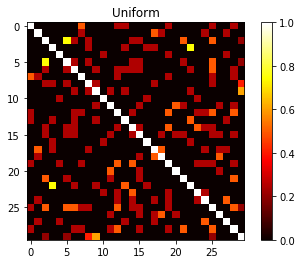

In [17]:
kernel_matrix = spectrum_kernel(np.asarray(uni_rec))

plt.imshow(kernel_matrix, cmap = 'hot', interpolation='nearest')
#plt.imshow(sorted_new_kernel_matrix, cmap = 'hot')
plt.colorbar()
plt.title('Uniform')

['aaa', 'aag', 'aat', 'aca', 'acg', 'act', 'aga', 'agc', 'agg', 'agt', 'ata', 'atg', 'att', 'caa', 'cac', 'cat', 'cca', 'ccg', 'cgc', 'cgg', 'cgt', 'cta', 'ctg', 'gaa', 'gac', 'gag', 'gcc', 'gcg', 'gga', 'ggc', 'ggg', 'ggt', 'gta', 'gtc', 'gtg', 'taa', 'tac', 'tag', 'tat', 'tcc', 'tct', 'tga', 'tgg', 'tgt', 'ttg', 'ttt']
[[0.5 0.5 0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.5 0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]
[[0.5 0.5 0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.5 0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]
[[0.5 0.  0.  ... 0.  0.  0. ]
 [0.5 0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.5 0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]


Text(0.5, 1.0, 'PPM')

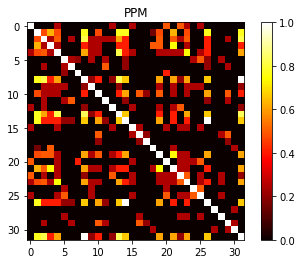

In [18]:
kernel_matrix = spectrum_kernel(np.asarray(ppm_rec))

plt.imshow(kernel_matrix, cmap = 'hot', interpolation='nearest')
#plt.imshow(sorted_new_kernel_matrix, cmap = 'hot')
plt.colorbar()
plt.title('PPM')

['aaa', 'aac', 'aag', 'aat', 'aca', 'acc', 'acg', 'act', 'aga', 'agc', 'agg', 'agt', 'ata', 'atc', 'atg', 'att', 'caa', 'cac', 'cag', 'cat', 'cca', 'ccc', 'ccg', 'cct', 'cga', 'cgc', 'cgg', 'cgt', 'cta', 'ctc', 'ctg', 'ctt', 'gaa', 'gac', 'gag', 'gat', 'gcc', 'gcg', 'gct', 'gga', 'ggc', 'ggg', 'ggt', 'gta', 'gtc', 'gtg', 'gtt', 'taa', 'tac', 'tag', 'tat', 'tca', 'tcc', 'tct', 'tga', 'tgc', 'tgg', 'tgt', 'tta', 'ttg', 'ttt']
[[0.  0.  0.  ... 0.  0.5 0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.5 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.5 0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]
[[0.         0.         0.         ... 0.         0.5        0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.5        ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.5        0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.816496

Text(0.5, 1.0, 'Uniform vs. PPM')

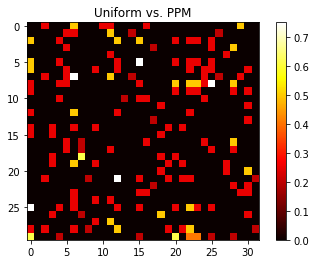

In [19]:
kernel_matrix = spectrum_kernel(np.asarray(uni_rec), np.asarray(ppm_rec))

plt.imshow(kernel_matrix, cmap = 'hot', interpolation='nearest')
#plt.imshow(sorted_new_kernel_matrix, cmap = 'hot')
plt.colorbar()
plt.title('Uniform vs. PPM')

['aaa', 'aac', 'aag', 'aat', 'aca', 'acg', 'act', 'aga', 'agc', 'agg', 'agt', 'ata', 'atg', 'att', 'caa', 'cac', 'cag', 'cat', 'cca', 'ccg', 'cgc', 'cgg', 'cgt', 'cta', 'ctg', 'ctt', 'gaa', 'gac', 'gag', 'gcc', 'gcg', 'gga', 'ggc', 'ggg', 'ggt', 'gta', 'gtc', 'gtg', 'gtt', 'taa', 'tac', 'tag', 'tat', 'tca', 'tcc', 'tct', 'tga', 'tgg', 'tgt', 'tta', 'ttc', 'ttg', 'ttt']
[[0.5 0.  0.5 ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.5 ... 0.  0.  0.5]
 [0.  0.  0.5 ... 0.  0.  0.5]
 [0.  0.  0.5 ... 0.  0.  0.5]]
[[0.5 0.  0.5 ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.5 0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.5 0.  0.  ... 0.5 0.5 0.5]]


Text(0.5, 1.0, 'Uniform vs. PPM')

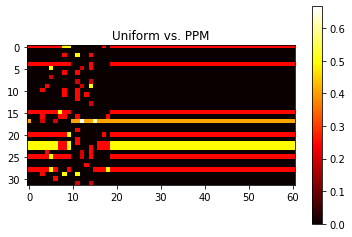

In [21]:
kernel_matrix = spectrum_kernel(np.asarray(ppm_rec), np.asarray(rbs1by1))

plt.imshow(kernel_matrix, cmap = 'hot', interpolation='nearest')
#plt.imshow(sorted_new_kernel_matrix, cmap = 'hot')
plt.colorbar()
plt.title('Uniform vs. PPM')